# Predicting Perception of IAQ
Adaptation of Mengjia Tang's analysis

# Library Import

## Basics

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import time
import random

## SkLearn

In [2]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn import preprocessing
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression, LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, cohen_kappa_score, confusion_matrix, precision_recall_curve, f1_score, auc

## Other

In [3]:
import shap

# Data Summary

In [4]:
df = pd.read_csv("../data/processed/iaq_perception-mt.csv")
df.head()

,Home_ID,FloorArea_sqft,CeilingHgt_ft,N_Bedrm,N_FullBath,N_HalfBath,Oven_Fuel,Num_Occupant,WHV_AsFound,AF1_Condition,...,NO2_AQL_IN1,FRM_ADJ_IN1,FRM_ADJ_BR1,T_ETC_IN1,RH_ETC_IN1,FRM_IN_ppb,NO2_IAQm_ppb,NOx_IAQm_ppb,Satisfaction_3points,Satisfaction_2points
0,1,2001,9,3,2,1,1,4.0,0.0,3.0,...,0.021302,10.522139,12.337049,23.269313,39.705435,14.252478,4.874853,20.336480,0,0
1,3,3104,10,4,3,0,0,2.0,1.0,1.0,...,0.048584,39.239283,42.685868,24.420784,45.021151,NaN,NaN,NaN,1,1
2,4,3248,11,3,3,1,0,2.0,0.0,1.0,...,0.153633,16.158558,16.637428,20.264354,45.067446,20.250339,1.708403,2.617361,1,1
3,5,2317,9,4,2,0,1,3.0,0.0,1.0,...,0.049589,23.635695,27.127771,25.372127,37.459627,NaN,2.776921,7.139446,0,0
4,6,3108,11,3,2,1,0,2.0,0.0,1.0,...,0.250460,27.351496,43.769564,25.585127,38.000461,44.742541,5.076926,25.850207,0,0


In [5]:
# Imputation with median
imp_median = SimpleImputer(missing_values=np.nan, strategy='median')
df_m = pd.DataFrame(data=imp_median.fit_transform(df),columns=df.columns)

## Building Characteristics

In [6]:
X1 = df_m.iloc[:,1:15]
X1.head()

,FloorArea_sqft,CeilingHgt_ft,N_Bedrm,N_FullBath,N_HalfBath,Oven_Fuel,Num_Occupant,WHV_AsFound,AF1_Condition,RHD_Grease_Screen_Condition,RHD_Fan_Airflow_Adjusted_Low_cfm,RHD_Fan_Airflow_Adjusted_High_cfm,EXF_BA1_Measured_cfm,Depressurization_Q50_cfm
0,2001.0,9.0,3.0,2.0,1.0,1.0,4.0,0.0,3.0,2.0,88.505747,133.333333,91.0,1006.0
1,3104.0,10.0,4.0,3.0,0.0,0.0,2.0,1.0,1.0,1.0,107.000000,326.000000,49.0,1548.5
2,3248.0,11.0,3.0,3.0,1.0,0.0,2.0,0.0,1.0,2.0,310.000000,1046.000000,101.0,2224.0
3,2317.0,9.0,4.0,2.0,0.0,1.0,3.0,0.0,1.0,1.0,81.609195,143.678161,81.5,1548.5
4,3108.0,11.0,3.0,2.0,1.0,0.0,2.0,0.0,1.0,1.0,360.000000,806.000000,81.0,1548.5


## Air Quality

In [7]:
X2 = df_m.iloc[:,15:27]
X2.head()

,PM_MET_IN1,PM_MET_OUT,CO2_ETC_IN1,CO2_ETC_BR1,NO2_AQL_IN1,FRM_ADJ_IN1,FRM_ADJ_BR1,T_ETC_IN1,RH_ETC_IN1,FRM_IN_ppb,NO2_IAQm_ppb,NOx_IAQm_ppb
0,2.011464,8.855427,640.476489,727.076213,0.021302,10.522139,12.337049,23.269313,39.705435,14.252478,4.874853,20.336480
1,5.959333,2.406069,830.593753,846.815114,0.048584,39.239283,42.685868,24.420784,45.021151,18.010887,5.502727,18.359575
2,11.291269,4.427615,512.227439,605.783042,0.153633,16.158558,16.637428,20.264354,45.067446,20.250339,1.708403,2.617361
3,1.074514,3.324214,671.966967,734.965862,0.049589,23.635695,27.127771,25.372127,37.459627,18.010887,2.776921,7.139446
4,3.883027,4.623322,603.374908,684.653495,0.250460,27.351496,43.769564,25.585127,38.000461,44.742541,5.076926,25.850207


## Target

In [8]:
Y1 = df_m.iloc[:,28]

---

# Feature Selection

In [9]:
def get_feature_importance(model,X_train,y_train):
    """
    Gets a DataFrame of the feature importances
    """
    try:
        model.fit(X_train,y_train)
        importances = pd.DataFrame(data={
            'Feature': X_train.columns,
            'Importance': model.feature_importances_
        })
        importances = importances.sort_values(by='Importance', ascending=False)
        return importances
    except:
        print("Not a valid model")
        return

## Standardizing Features

In [10]:
def scale_x(x,verbose=False):
    """
    Scales the given array
    """
    # scaling
    scaler = preprocessing.StandardScaler().fit(x)
    X_scaled = scaler.transform(x)
    
    # checking
    if verbose:
        print("Should be approximately zero:", X_scaled.mean(axis=0))
        print("Should be approximately one:",X_scaled.std(axis=0))
    
    return pd.DataFrame(data=X_scaled,columns=x.columns)

## Getting Complete Featureset
We include the features that Mengjia found relevant

In [11]:
X_all = df_m.iloc[:,np.r_[1:15,15:19,22:27]]
X_all.head()

,FloorArea_sqft,CeilingHgt_ft,N_Bedrm,N_FullBath,N_HalfBath,Oven_Fuel,Num_Occupant,WHV_AsFound,AF1_Condition,RHD_Grease_Screen_Condition,...,Depressurization_Q50_cfm,PM_MET_IN1,PM_MET_OUT,CO2_ETC_IN1,CO2_ETC_BR1,T_ETC_IN1,RH_ETC_IN1,FRM_IN_ppb,NO2_IAQm_ppb,NOx_IAQm_ppb
0,2001.0,9.0,3.0,2.0,1.0,1.0,4.0,0.0,3.0,2.0,...,1006.0,2.011464,8.855427,640.476489,727.076213,23.269313,39.705435,14.252478,4.874853,20.336480
1,3104.0,10.0,4.0,3.0,0.0,0.0,2.0,1.0,1.0,1.0,...,1548.5,5.959333,2.406069,830.593753,846.815114,24.420784,45.021151,18.010887,5.502727,18.359575
2,3248.0,11.0,3.0,3.0,1.0,0.0,2.0,0.0,1.0,2.0,...,2224.0,11.291269,4.427615,512.227439,605.783042,20.264354,45.067446,20.250339,1.708403,2.617361
3,2317.0,9.0,4.0,2.0,0.0,1.0,3.0,0.0,1.0,1.0,...,1548.5,1.074514,3.324214,671.966967,734.965862,25.372127,37.459627,18.010887,2.776921,7.139446
4,3108.0,11.0,3.0,2.0,1.0,0.0,2.0,0.0,1.0,1.0,...,1548.5,3.883027,4.623322,603.374908,684.653495,25.585127,38.000461,44.742541,5.076926,25.850207


#### Splitting

In [12]:
X_scaled_all = scale_x(X_all)
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(X_scaled_all, Y1, test_size = 0.1, random_state=0)

## Gridsearch for Optimal DT and RF Parameters
We need to somewhat optimize the DT and RF models to the entire featureset so that we are at more aptly determining the important features.

### DT

In [13]:
fs_DT = DecisionTreeClassifier(random_state=42)
parameters = {'ccp_alpha':np.arange(0,0.1,0.005),'criterion':['entropy',"gini"],'max_depth':np.arange(3,9,1)}
fs_DT_grid = GridSearchCV(fs_DT, parameters, cv=10, refit=True, scoring='accuracy')
fs_DT_grid.fit(X_train_all, y_train_all)
for key, val in fs_DT_grid.best_params_.items():
    print(f"{key}: {val}")
print("score:",fs_DT_grid.best_score_)

ccp_alpha: 0.0
criterion: entropy
max_depth: 8
score: 0.675


### RF

In [14]:
fs_RF = RandomForestClassifier(random_state=42)
parameters = {'ccp_alpha':np.arange(0,0.05,0.005),'criterion':['entropy','gini'],'max_depth':np.arange(3,9,1),'n_estimators':[10,20,50,100]}
fs_RF_grid = GridSearchCV(fs_RF, parameters, cv=10, refit=True,scoring='accuracy')
fs_RF_grid.fit(X_train_all, y_train_all)
for key, val in fs_RF_grid.best_params_.items():
    print(f"{key}: {val}")
print("score:",fs_RF_grid.best_score_)

ccp_alpha: 0.03
criterion: gini
max_depth: 7
n_estimators: 20
score: 0.7375


## Feature Importances
Using the optimized models from above to get the important features

See some good articles here about SHAP values - **NOT USED**:
* [RF Models](https://towardsdatascience.com/explain-your-model-with-the-shap-values-bc36aac4de3d)
* [Other Models](https://towardsdatascience.com/explain-any-models-with-the-shap-values-use-the-kernelexplainer-79de9464897a)

And the [Github](https://github.com/slundberg/shap) for this library.

### DT

In [15]:
fs_DT_imp = get_feature_importance(DecisionTreeClassifier(random_state=42,ccp_alpha=0.0,criterion="entropy",max_depth=8),
                                   X_train_all,y_train_all)
fs_DT_imp.reset_index(drop=True,inplace=True)
fs_DT_imp["Rank"] = fs_DT_imp.index
fs_DT_imp[:5]

,Feature,Importance,Rank
0,CO2_ETC_BR1,0.266724,0
1,RH_ETC_IN1,0.225970,1
2,RHD_Fan_Airflow_Adjusted_Low_cfm,0.149999,2
3,PM_MET_IN1,0.110046,3
4,FRM_IN_ppb,0.103581,4


### RF

In [16]:
fs_RF_imp = get_feature_importance(RandomForestClassifier(random_state=42,ccp_alpha=0.0,criterion="gini",max_depth=6,n_estimators=50),
                                   X_train_all,y_train_all)
fs_RF_imp.reset_index(drop=True,inplace=True)
fs_RF_imp["Rank"] = fs_RF_imp.index
fs_RF_imp[:5]

,Feature,Importance,Rank
0,Depressurization_Q50_cfm,0.090587,0
1,RHD_Fan_Airflow_Adjusted_Low_cfm,0.085150,1
2,CO2_ETC_IN1,0.079898,2
3,FRM_IN_ppb,0.069125,3
4,EXF_BA1_Measured_cfm,0.062588,4


### Getting Top Feature

In [17]:
comb_imp = fs_RF_imp.merge(right=fs_DT_imp,on="Feature",suffixes=["_RF","_DT"])
comb_imp["Importance"] = (1 - comb_imp["Importance_RF"]) + (1- comb_imp["Importance_DT"])
comb_imp["Rank"] = comb_imp["Rank_RF"] + comb_imp["Rank_DT"]
comb_imp.sort_values(["Rank","Importance"],ascending=True)[:11]

,Feature,Importance_RF,Rank_RF,Importance_DT,Rank_DT,Importance,Rank
1,RHD_Fan_Airflow_Adjusted_Low_cfm,0.085150,1,0.149999,2,1.764851,3
6,CO2_ETC_BR1,0.054882,6,0.266724,0,1.678394,6
3,FRM_IN_ppb,0.069125,3,0.103581,4,1.827294,7
7,RH_ETC_IN1,0.054273,7,0.225970,1,1.719757,8
0,Depressurization_Q50_cfm,0.090587,0,0.000000,11,1.909413,11
2,CO2_ETC_IN1,0.079898,2,0.000000,9,1.920102,11
4,EXF_BA1_Measured_cfm,0.062588,4,0.000000,7,1.937412,11
9,PM_MET_IN1,0.048619,9,0.110046,3,1.841335,12
5,NO2_IAQm_ppb,0.061923,5,0.000000,8,1.938077,13
12,NOx_IAQm_ppb,0.042312,12,0.077674,5,1.880014,17


We will include the top nine features but exclude the `CO2_ETC_IN1` since we already have a measure of CO$_2$ from the bedroom which is more telling. We will also include `T_ETC_IN1` since this variable is included in the other analysis.

## Defining Important Features as ```X```
From the results above, we get the important features:

In [13]:
X = df_m[[col for col in ["CO2_ETC_BR1","RH_ETC_IN1","PM_MET_IN1","NO2_IAQm_ppb","FRM_IN_ppb","T_ETC_IN1",
                          "RHD_Fan_Airflow_Adjusted_Low_cfm","Depressurization_Q50_cfm","EXF_BA1_Measured_cfm"]]]
X.head()

,CO2_ETC_BR1,RH_ETC_IN1,PM_MET_IN1,NO2_IAQm_ppb,FRM_IN_ppb,T_ETC_IN1,RHD_Fan_Airflow_Adjusted_Low_cfm,Depressurization_Q50_cfm,EXF_BA1_Measured_cfm
0,727.076213,39.705435,2.011464,4.874853,14.252478,23.269313,88.505747,1006.0,91.0
1,846.815114,45.021151,5.959333,5.502727,18.010887,24.420784,107.000000,1548.5,49.0
2,605.783042,45.067446,11.291269,1.708403,20.250339,20.264354,310.000000,2224.0,101.0
3,734.965862,37.459627,1.074514,2.776921,18.010887,25.372127,81.609195,1548.5,81.5
4,684.653495,38.000461,3.883027,5.076926,44.742541,25.585127,360.000000,1548.5,81.0


<div class="alert alert-block alert-info">
 
We have 9 features to include:
* IAQ: CO2 (bedroom), RH, PM, NO2, HCHO, T
* HVAC: Fan airflow, Q50, Exfiltration (bathroom)
    
</div>

In [14]:
X_scaled = scale_x(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y1, test_size = 0.1, random_state=0)

---

# Defining Full Model
To compare, we need to generate the full model

## Tuning Hyperparameters

### LR

In [15]:
def optimize_lr(X,y):
    """
    optimizes the LR parameters
    """
    test_LR = LogisticRegression(random_state=0)
    parameters = {'fit_intercept':[True,False],"solver":["lbfgs","liblinear"]}
    test_LR_grid = GridSearchCV(test_LR, parameters, cv=10, refit=True, scoring='accuracy')
    test_LR_grid.fit(X, y)
    for key, val in test_LR_grid.best_params_.items():
        print(f"{key}: {val}")

In [16]:
optimize_lr(X_train_all,y_train_all)

fit_intercept: False
solver: lbfgs


In [17]:
model_LR_full = LogisticRegression(random_state=42,fit_intercept=False,solver="lbfgs")

### DT

In [23]:
def optimize_dt(X,y):
    """
    optimizes parameters for DT model
    """
    test_DT = DecisionTreeClassifier(random_state=0)
    parameters = {'ccp_alpha':np.arange(0,0.1,0.005),'criterion':['entropy',"gini"],'max_depth':np.arange(2,11,1)}
    test_DT_grid = GridSearchCV(test_DT, parameters, cv=10, refit=True,scoring='accuracy')
    test_DT_grid.fit(X, y)
    for key, val in test_DT_grid.best_params_.items():
        print(f"{key}: {val}")
    print("score:", test_DT_grid.best_score_)

In [24]:
optimize_dt(X_train_all,y_train_all)

ccp_alpha: 0.04
criterion: entropy
max_depth: 9
score: 0.7


In [18]:
model_DT_full = DecisionTreeClassifier(random_state=42,ccp_alpha=0.04,criterion="entropy",max_depth=9)

### RF

In [26]:
def optimize_rf(X,y):
    """
    optimizes parameters for RF model
    """
    test_RF = RandomForestClassifier(random_state=0)
    parameters = {'ccp_alpha':np.arange(0,0.05,0.005),'criterion':['gini','entropy'],'max_depth':np.arange(3,9,1),'n_estimators':[10,20,50,100]}
    test_RF_grid = GridSearchCV(test_RF, parameters, cv=10, refit=True,scoring='accuracy')
    test_RF_grid.fit(X, y)
    for key, val in test_RF_grid.best_params_.items():
        print(f"{key}: {val}")
    print("score:",test_RF_grid.best_score_)

In [27]:
optimize_rf(X_train_all,y_train_all)

ccp_alpha: 0.0
criterion: gini
max_depth: 6
n_estimators: 50
score: 0.6875


In [19]:
model_RF_full = RandomForestClassifier(random_state=42,ccp_alpha=0.0,criterion="gini",max_depth=6,n_estimators=50)

## Defining

In [20]:
models_full = {"LR":model_LR_full,"DT":model_DT_full,"NB":GaussianNB(),"RF":model_RF_full}

---

# Defining Lite Model
Now that we have the important features, we need to tune the models

## Tuning Hyperparameters

### Logistic Regression

In [30]:
optimize_lr(X_train,y_train)

fit_intercept: False
solver: lbfgs


In [21]:
model_LR_lite = LogisticRegression(random_state=42,fit_intercept=False,solver="lbfgs",max_iter=1000)

### Decision Tree

In [32]:
optimize_dt(X_train,y_train)

ccp_alpha: 0.0
criterion: entropy
max_depth: 8
score: 0.7


In [22]:
model_DT_lite = DecisionTreeClassifier(random_state=42,ccp_alpha=0.0,criterion="entropy",max_depth=8)

### Random Forest

In [34]:
optimize_rf(X_train,y_train)

ccp_alpha: 0.0
criterion: entropy
max_depth: 8
n_estimators: 20
score: 0.7375


In [23]:
model_RF_lite = RandomForestClassifier(random_state=42,ccp_alpha=0.0,criterion="entropy",max_depth=8,n_estimators=20)

## Defining

In [24]:
models_lite = {"LR":model_LR_lite,"DT":model_DT_lite,"NB":GaussianNB(),"RF":model_RF_lite}

---

# Comparing Lite and Full Models
Following Mengjia's analysis, we compare the accuracy and CV from the lite and full models.

## Lite

In [25]:
for label, model in models_lite.items(): 
    print(label,model)

LR LogisticRegression(fit_intercept=False, max_iter=1000, random_state=42)
DT DecisionTreeClassifier(criterion='entropy', max_depth=8, random_state=42)
NB GaussianNB()
RF RandomForestClassifier(criterion='entropy', max_depth=8, n_estimators=20,
                       random_state=42)


In [26]:
res_lite = {"model":[],"cv_mean":[],"cv_std":[],"accuracy":[]}
preds_lite = {"model":[],"predictions":[]}
for label, model in models_lite.items():
    # CV score
    cv_score = cross_val_score(model, X_train, y_train, cv=10, scoring='accuracy')
    
    # Prediction accuracy
    model.fit(X_train, y_train)
    pred_lite = model.predict(X_test)
    ## saving to dict
    preds_lite["model"].append(label)
    preds_lite["predictions"].append(pred_lite)
    
    # Updating comparison dict
    for key, val in zip(res_lite.keys(),[label,cv_score.mean(),cv_score.std(),accuracy_score(pred_lite,y_test)]):
        res_lite[key].append(val)
        
res_lite_df = pd.DataFrame(res_lite)

## Full

In [27]:
res_full = {"model":[],"cv_mean":[],"cv_std":[],"accuracy":[]}
for label, model in models_full.items():
    # CV score
    cv_score = cross_val_score(model, X_train_all, y_train_all, cv=10, scoring='accuracy')
    
    # Prediction accuracy
    model.fit(X_train_all, y_train_all)
    pred_full = model.predict(X_test_all)
    
    # Updating comparison dict
    for key, val in zip(res_lite.keys(),[label,cv_score.mean(),cv_score.std(),accuracy_score(pred_full,y_test)]):
        res_full[key].append(val)
        
res_full_df = pd.DataFrame(res_full)

## Comparison

In [28]:
res_lite_df

,model,cv_mean,cv_std,accuracy
0,LR,0.5750,0.150000,0.555556
1,DT,0.7125,0.194052,0.666667
2,NB,0.5750,0.217945,0.777778
3,RF,0.5875,0.216867,0.888889


In [29]:
res_full_df

,model,cv_mean,cv_std,accuracy
0,LR,0.5500,0.150000,0.555556
1,DT,0.6625,0.185826,0.777778
2,NB,0.6250,0.185405,0.666667
3,RF,0.5750,0.139194,0.777778


## Check with Random Targets

In [30]:
res_random_full = {"model":[],"cv_mean":[],"accuracy":[]}

for i in range(10):
    Y_random = np.array(random.sample(list(Y1), len(Y1)))
    X_train_rand, X_test_rand, y_train_rand, y_test_rand = train_test_split(X_scaled_all, Y_random, test_size=0.1)
    for label, model in models_full.items():

        # train model
        model.fit(X_train_rand,y_train_rand)

        # cross validate model with 10-fold cv
        cv_mean = cross_val_score(model, X_train_rand, y_train_rand, cv=10).mean()

        # accuracy
        acc = model.score(X_test_rand,y_test_rand)
        
        # update dict
        for key, val in zip(res_random_full.keys(),[label,cv_mean,acc]):
            res_random_full[key].append(val)

In [31]:
res_random_full_avg = pd.DataFrame(res_random_full).groupby("model").mean()
res_random_full_avg

,cv_mean,accuracy
model,,
DT,0.47750,0.488889
LR,0.49250,0.488889
NB,0.49875,0.422222
RF,0.46500,0.411111


---

# Evaluation

## Metrics

In [32]:
splits=5
cv = StratifiedKFold(n_splits=splits)
        
final_accuracies = []
final_fscores = []
final_thresholds = []
final_aucs = []
final_naives = []
final_feature_importances = {new_list: [] for new_list in models_lite.keys()}
for name, model in models_lite.items():
    precisions = []
    thresholds = []
    accuracies = []
    mean_recall = np.linspace(0, 1, 100)
    feature_importances = []
    fscores_balanced = []
    for i, (train, test) in enumerate(cv.split(X, Y1)):
        clf = model.fit(X.iloc[train],Y1.iloc[train])
        precision, recall, threshold = precision_recall_curve(Y1.iloc[test], clf.predict_proba(X.iloc[test])[:, 1])
        precisions.append(np.interp(mean_recall, np.sort(recall), precision))
        thresholds.append(np.interp(mean_recall, np.sort(recall), np.append(threshold,[1])))
        fscores_balanced.append(f1_score(Y1.iloc[test],clf.predict(X.iloc[test])))
        accuracies.append(accuracy_score(Y1.iloc[test],clf.predict(X.iloc[test])))
        if name in ["DT","RF"]:
            feature_importances.append(clf.feature_importances_)
        elif name == "LR":
            feature_importances.append(clf.coef_[0])
        else:
            feature_importances.append(np.zeros(len(X.columns)))

    final_feature_importances[name] = pd.DataFrame(data=feature_importances).mean(axis=0).values
    mean_precision = np.mean(precisions, axis=0)
    mean_threshold = np.mean(thresholds, axis=0)
    mean_auc = auc(mean_recall,mean_precision)
    fscore = (2 * mean_precision * mean_recall[::-1]) / (mean_precision + mean_recall[::-1])
    # locate the index of the largest f score
    ix = np.argmax(fscore)
    score = round(sum(Y1)/len(Y1),2)
    print(f'Model={name}\n\tAccuracy = {round(np.mean(accuracies),2)}\n\tF-Score (adjusted) = {round(fscore[ix],2)} ({round(mean_threshold[ix],2)})\n\tPR_AUC = {round(mean_auc,2)}\n\tNaive Score = {score if score > 0.5 else 1-score}')

    for val, li in zip([round(np.mean(accuracies),2),round(fscore[ix],2),round(mean_threshold[ix],2),round(mean_auc,2),score if score > 0.5 else 1-score],[final_accuracies,final_fscores,final_thresholds,final_aucs,final_naives]):
        li.append(val)

metrics_lite, feature_importances = pd.DataFrame(data={"F1":final_fscores,"threshold":final_thresholds,"PR AUC":final_aucs,"Accuracy":final_accuracies,"Naive":final_naives}), final_feature_importances

Model=LR
	Accuracy = 0.54
	F-Score (adjusted) = 0.71 (0.24)
	PR_AUC = 0.6
	Naive Score = 0.52
Model=DT
	Accuracy = 0.57
	F-Score (adjusted) = 0.65 (0.0)
	PR_AUC = 0.6
	Naive Score = 0.52
Model=NB
	Accuracy = 0.56
	F-Score (adjusted) = 0.72 (0.28)
	PR_AUC = 0.63
	Naive Score = 0.52
Model=RF
	Accuracy = 0.57
	F-Score (adjusted) = 0.7 (0.31)
	PR_AUC = 0.65
	Naive Score = 0.52


In [33]:
metrics_lite["Model"] = ["LR","DT","NB","RF"]
metrics_lite.set_index("Model",inplace=True)
print(metrics_lite.to_latex())

\begin{tabular}{lrrrrr}
\toprule
{} &    F1 &  threshold &  PR AUC &  Accuracy &  Naive \\
Model &       &            &         &           &        \\
\midrule
LR    &  0.71 &       0.24 &    0.60 &      0.54 &   0.52 \\
DT    &  0.65 &       0.00 &    0.60 &      0.57 &   0.52 \\
NB    &  0.72 &       0.28 &    0.63 &      0.56 &   0.52 \\
RF    &  0.70 &       0.31 &    0.65 &      0.57 &   0.52 \\
\bottomrule
\end{tabular}



---

# Figures

## Feature Relationships

In [53]:
def plot_feature_relationships(x_loc,y_loc,z_loc,target_loc=28,save=False):
    """
    Plots the relationship between three features
    
    Parameters
    ----------
    
    Returns
    -------
    <void>
    """
    try:
        # features
        x = df.iloc[:,x_loc] #Depression
        y = df.iloc[:,y_loc] #RHD_Low
        z = df.iloc[:,z_loc] #RH
        # target
        target = df.iloc[:,target_loc] 
    except ValueError:
        print("Use the `iloc` locations")
        return
    
    fig, ax = plt.subplots(frameon=False)
    fig.set_size_inches(8,6)
    mi = np.min(z)
    ma = np.max(z)
    norm = matplotlib.colors.Normalize(vmin=mi,vmax=ma)
    im0=ax.scatter(x[target==0], y[target==0], alpha=0.6, c=z[target==0], cmap='jet',marker='o',s=100,norm=norm,edgecolor="black",label = 'Class 0')
    im=ax.scatter(x[target==1], y[target==1], alpha=0.6, c=z[target==1], cmap='jet',marker='^',s=100,norm=norm,edgecolor="black", label = 'Class 1')
    cbar = fig.colorbar(im, ax=ax)
    cbar.solids.set(alpha=0.6)
    cbar.ax.set_ylabel('RH (%)',fontsize=18)
    cbar.ax.tick_params(labelsize=14)
    plt.xlabel('Q50 (cfm)',fontsize=18)
    plt.ylabel('RHD_Low (cfm)',fontsize=18)
    ax.legend([im0,im],["Class 0","Class 1"],fontsize=18,loc='upper left',frameon=False)
    ax.tick_params(axis='both', which='major', labelsize=14)
    plt.xlim(0,  3500)
    plt.ylim(-5,  350)
    for loc in ["top","right"]:
        ax.spines[loc].set_visible(False)
    
    if save:
        plt.savefig(f"../reports/figures/prediction/iaq_perception-feature_relationship-{x_loc}_{y_loc}_{z_loc}.pdf",bbox_inches="tight")
    
    plt.show()
    plt.close()

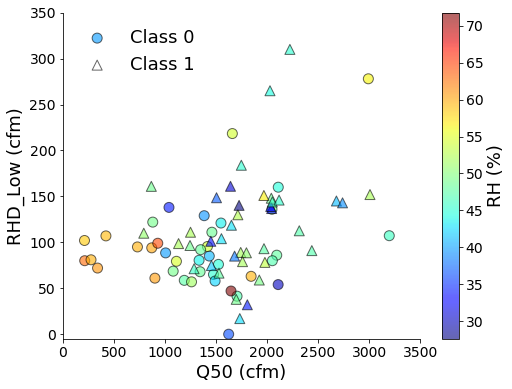

In [55]:
plot_feature_relationships(14,11,23,save=True)

## Feature Correlation

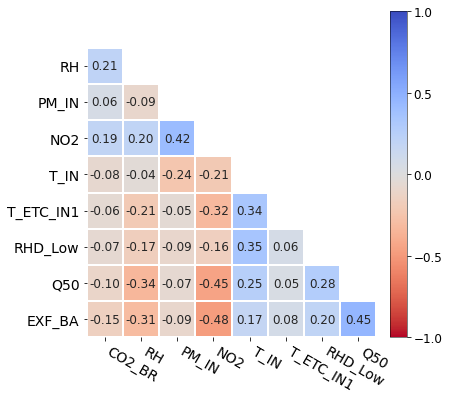

In [38]:
_, ax = plt.subplots(figsize=(8,6)) 
X_df = X.copy()
X_df.rename({"CO2_ETC_BR1":"CO2_BR", "RH_ETC_IN1":"RH", "PM_MET_IN1":"PM_IN", "NO2_IAQm_ppb":"NO2", "FRM_IN_ppb":"FRM", "FRM_IN_ppb":"T_IN",
             "RHD_Fan_Airflow_Adjusted_Low_cfm":"RHD_Low","Depressurization_Q50_cfm":"Q50", "EXF_BA1_Measured_cfm":"EXF_BA"},axis="columns",inplace=True)
corr = X_df.corr()
# generating a mask for upper only
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
# plotting
sns.heatmap(corr,vmin=-1,vmax=1,lw=2,mask=mask,square=True,
            annot_kws={'size':12},fmt=".2f",annot=True,
            cmap="coolwarm_r",cbar_kws={"ticks":np.arange(-1,1.5,0.5),"pad":-0.05},ax=ax)
# formatting x
ax.set_xticks(np.arange(0.5,len(X_df.columns)-1,1))
ax.set_xticklabels(X_df.columns[:-1],rotation=-30,ha="left",fontsize=14)
# formatting y
ax.set_yticks(np.arange(1.5,len(X_df.columns),1))
ax.set_yticklabels(X_df.columns[1:],fontsize=14)
# colorbar
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=12)
cbar.outline.set_color('black')
cbar.outline.set_linewidth(0.5)

plt.savefig("../reports/figures/prediction/iaq_perception-feature_correlation.pdf",bbox_inches="tight")
plt.show()
plt.close()

---